# Кластеризация

В данной тетради рассматривается решение задачи кластерного анализа алгоритмами иерархической кластеризации. Показаны возможности библиотек Python непосредственно по решению задачи кластеризации, извлечению нужной структуры кластеров и их графического представления.    
Общая схема решения задачи:     
1. Чтение исходных данных (формат файла, формат записей, кодировка и т.п.);
2. Получение предварительной информации об имеющимся массива (просмотр заголовков, размерность, просмотр части данных, получение информации о типах данных, преобразование типов, поиск пропусков, заполнение пропусков);
3. Аккуратные данные (поиск и заполнение пропусков, поиск и удаление дубликатов, формирование итогового набора данных для кластеризации);
4. Иерархическая кластеризация: агломеративный алгоритм.


Дополнительные источники для изучения указаны в конце настоящей тетради. 

## 1. Чтение исходных данных

Для ознакомления с необходимым материал рекомендую книгу [1, глава 6, стр. 175].     
В рассматриваемом примере исходные данные хранятся в txt-файле, разделенные знаком табуляции.    
Для чтения воспользуемся функцией `.read_table()`.    
В качестве параметров передадим
- `path` -- путь к файлу;
- `encoding` -- исходную кодировку, в которой хранятся данные;
- `sep` -- последовательность символов или регулярное выражение, служащее для разделения полей в строке: ',',';','\t'(знак табуляции), '\s+' -- если поля разделены переменным числом пробелов;
- `nrows` -- количество читаемых строк от начала файла.

Подключаем библиотеку `pandas` и загружаем исходные данные в датафрейм `df`. 

ВАЖНО: В данном случае с целью упрощения и повышения производительности прочитаны только первых 100 строк исходного массива.

In [1]:
import pandas as pd
pd.set_option('display.precision',3)
df=pd.read_table('mobile.txt', encoding='1251', sep='\t', nrows=100)

## 2. Получение предварительной информации об имеющимся массива   

Для получения предварительной информации об анализируемом массиве можно воспользоваться следующими возможностями Python    
- Просмотр с помощью свойства `.head()` указанного числа первых строк датафрейма. По умолчанию выводится 5 первых строк датафрейма;
- Размерность датафрейма можно узнать с помощью свойства .shape;
- Просмотр заголовков столбов с помощью свойства .columns;
- Просмотр информации о типах переменных с помощью свойства `.info()`

In [2]:
df.head()

,Код,Возраст,Среднемесячный расход,Средняя продолжительность разговоров,Звонков днем за месяц,Звонков вечером за месяц,Звонков ночью за месяц,Звонки в другие города,Звонки в другие страны,Доля звонков на стационарные телефоны,Количество SMS за месяц
0,0,24,121.54,2.4,12,65,5,0,0,5,56
1,1,51,287.51,1.7,111,109,1,44,0,6,1
2,2,41,113.70,2.1,41,27,0,0,0,1,36
3,3,35,410.23,5.6,47,49,0,0,0,11,23
4,4,26,537.60,4.8,58,77,4,0,0,16,29


In [3]:
df.iloc[:,1:6:2]

,Возраст,Средняя продолжительность разговоров,Звонков вечером за месяц
0,24,2.4,65
1,51,1.7,109
2,41,2.1,27
3,35,5.6,49
4,26,4.8,77
...,...,...,...
95,29,18.2,78
96,54,1.1,68
97,25,3.7,45
98,54,2.8,98


ДОПОЛНИТЕЛЬНАЯ ИНФОРМАЦИЯ: С помощью свойства `.tail()` можно просмотреть заданное число последних строк массива. По умолчанию выводится 5 строк 

+ Размерность датафрейма можно узнать с помощью свойства `.shape`    
ДОПОЛНИТЕЛЬНАЯ ИНФОРМАЦИЯ: количество строк датафрейма можно узнать с помощью метода `len()`

In [4]:
df.shape

(100, 11)

+ Просмотр заголовков столбов с помощью свойства `.columns` 

In [5]:
df.columns

Index(['Код', 'Возраст', 'Среднемесячный расход',
       'Средняя продолжительность разговоров', 'Звонков днем за месяц',
       'Звонков вечером за месяц', 'Звонков ночью за месяц',
       'Звонки в другие города', 'Звонки в другие страны',
       'Доля звонков на стационарные телефоны', 'Количество SMS за месяц'],
      dtype='object')

## 3. Аккуратные данные

Аккуратные данные --- данные, пригодные для дальнейшего анализа. Для получения аккуратных данных необходимо разрешить следующие проблемы, связанные с имеющимися данными (список может быть расширен):     
- имена объектов или признаков отличаются от желаемых (требуемых);  
- есть пропущенные данные;
- значения указаны не в тех единицах измерения, которые требуются;
- временной период выборки наблюдений не тот;
- переменные являются категориальными, а требуются количественные;
- присутсвует шум в данных;
- информация неверного типа;
- данные неправильно ориентированы по осям;
- данные неправильно нормализованы;
- данные дублизуются.

## 3.1 Поиск и импутация пропущенных наблюдений
- Вывод общей информации о наличие пропусков во всех переменных можно осуществить, воспользовавшись цепочкой методов `.isnull()` и `.sum()`

In [6]:
df.isnull().sum()

Код                                      0
Возраст                                  0
Среднемесячный расход                    0
Средняя продолжительность разговоров     0
Звонков днем за месяц                    0
Звонков вечером за месяц                 0
Звонков ночью за месяц                   0
Звонки в другие города                   0
Звонки в другие страны                   0
Доля звонков на стационарные телефоны    0
Количество SMS за месяц                  0
dtype: int64

## 3.2 Типы признаков

Для просмотра информации о типах наблюдаемых признаков у объектов воспользуемся свойством `.info()`

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 11 columns):
Код                                      100 non-null int64
Возраст                                  100 non-null int64
Среднемесячный расход                    100 non-null float64
Средняя продолжительность разговоров     100 non-null float64
Звонков днем за месяц                    100 non-null int64
Звонков вечером за месяц                 100 non-null int64
Звонков ночью за месяц                   100 non-null int64
Звонки в другие города                   100 non-null int64
Звонки в другие страны                   100 non-null int64
Доля звонков на стационарные телефоны    100 non-null int64
Количество SMS за месяц                  100 non-null int64
dtypes: float64(2), int64(9)
memory usage: 8.7 KB


## 3.3 Генерирование входного массива и нормализация признаков 

In [8]:
X=df.iloc[:,:].values
X=(X-X.mean(axis=0))/X.std(axis=0)
#print(X.mean(axis=0)) #просмотр массива выборочных средних -- они должны быть равны 0 
#print(X.std(axis=0)) # просмотр массива стандартных отклонений --- они должны быть равными 1
#print(X) # просмотр входного массива --- аккуратные данные!!!!

## 4. Иерархическая кластеризация: агломеративный алгоритм

### 4.1 Реализация разбинения, матрица связей и ее интерпретация, визуализация

Для дополнительного изучения материала рекомендуется воспользоваться ресурсами [2, 3]    
Иерархическая кластеризация реализована в модуле `scipy.cluster.hierarchy`.    
Импортируем из этого модуля методы:    
- `.linkage()` -- выполняет иерархическую (агломеративную) кластеризацию; 
- `.dendrogram()` -- строит дендрограмму;
- `.fcluster()` -- 

Метод `.linkage()` имеет следующую спецификацию `linkage(X[, method, metric, optimal_ordering])`:    
- X -- матрица попарных расстояний или исходных данных (в матрице не должно быть пробелов или категориальных значений)
- method -- правило, по которому будут рассчитываться расстояния между кластерами:    
    - `single`
    - `complete`
    - `average`
    - `weighted`
    - `centroid`
    - `median`
    - `ward`
- metric -- метрика: `braycurtis`, `canberra`, `chebyshev`, `cityblock`, `correlation`, `cosine`, `dice`, `euclidean`, `hamming`, `jaccard`, `jensenshannon`, `kulsinski`, `mahalanobis`, `matching`, `minkowsk`, `rogerstanimoto`, `russellrao`, `seuclidean`, `sokalmichener`, `sokalsneath`, `sqeuclidean`, `yule`.

Результатом выполнения метода `.linkage()` является массив связей кластера. Обозначим его `Z`. Ниже дадим интерпретацию элементам массива `Z`.   

In [9]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt
import numpy as np

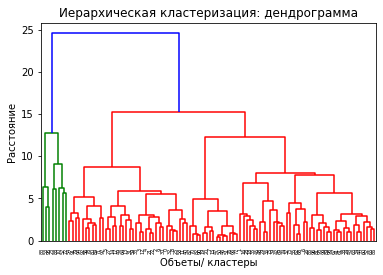

<Figure size 432x288 with 0 Axes>

In [11]:
Z = linkage(X, method='ward') 
plt.title('Иерархическая кластеризация: дендрограмма')
plt.xlabel('Объеты/ кластеры')
plt.ylabel('Расстояние')
dendrogram(Z) #рекомендуется посмотреть и другие параметры этого метода 
plt.show() #отобразить дендрограмму 
plt.savefig('1.png', dpi = 300) #сохранить рисунок

In [12]:
print(Z)

[[ 47.          50.           0.4064717    2.        ]
 [ 46.          51.           0.57310023   2.        ]
 [ 82.          90.           0.6078101    2.        ]
 [100.         101.           0.60829392   4.        ]
 [ 70.         102.           0.7341558    3.        ]
 [ 62.          68.           0.74577465   2.        ]
 [ 66.          77.           0.79800266   2.        ]
 [ 76.         106.           0.89208984   3.        ]
 [ 19.          20.           0.9228828    2.        ]
 [ 21.          22.           0.92367274   2.        ]
 [ 89.          98.           1.01020099   2.        ]
 [ 34.          44.           1.02297361   2.        ]
 [ 24.          43.           1.0234665    2.        ]
 [ 41.          61.           1.0512902    2.        ]
 [  3.          12.           1.05601407   2.        ]
 [ 29.          36.           1.05631448   2.        ]
 [  8.          25.           1.1240306    2.        ]
 [  7.          15.           1.12867273   2.        ]
 [ 32.    

Дадим интерпретацию элементам массив связей кластера `Z`. В первом и втором столбцах массива `Z` указаны индексы кластеров (в том числе синглетонов), объединяющих на текущей итерации. В третьем столбце находится расстояние между кластерами. В четвертом столбце индекс нового кластера, показыващий число синглетонов в новом кластере. Например, строка `Z[0]` содержит следующее `array([47., 50., 0.4064717, 2.])`. Элементы этой строки показывают, что на первой (напомним, что индексация массивов начинается с 0) итерации алгоритма объединяются кластеры (здесь синглетоны -- кластер, состоящий из одного элемента) с номерами `47` и `50`, расстояние между кластерами равно `0.4064717`, новому кластеру присвоен номер `2` -- по числу синглетонов в образовавшемся кластере, и т.д.    
Напомним, что в исходном массиве число объектов 100, проиндексированных от 0 до 99. Обратим внимание на строку массива `Z` с индексом 3. Строка `Z[3]` имеет вид `array([100., 101., 0.60829392, 4.])`. Имеем, что на данной итерации объединяются кластеры с индексами `100` и `101`. Однако в исходном множестве объектов максимальный индекс равен `99`. Индексы такие, что $idx \geqslant len(X)$ соответствуют кластерам, которые объединились ранее и находятся в массиве связей кластера в строке `Z[idx-len(X)]`, где $len(X)=100$. Имеем, индекс 100 соответствует кластеру, который образовался на 1 итерации алгоритма и находится в строке `Z[0]`. Видим, что в этой строке объединяются синглетоны с индексами `47` и `50`. Аналогичным образом, индекс 101 соответствует строке массива `Z[1]` --- здесь объединились синглетоны с индексами `46` и `51`. В результате в образовавшемся кластере находятся `4` синглетона.

### 4.2 Анализ результатов кластеризации: усеченная дендрограмма, выбор кластеров, вывод состава кластеров

Если количество элементов, подлежащих кластеризации велико, то можно отобразить усеченную дендрограмму. Усечение используется для сжатия дендрограммы. Для того, чтобы построить усеченную дендрограмму необходимо в команде `.dendrogram()` использовать режим `truncate_mode` со значением `lastp` или `level`.     
Если `truncate_mode='lastp'`, то отображается `p` последних образовавшихся кластера. В матрице связей $Z$ это соответствует строкам $Z[n-p-2:end]$. По оси абцисс в скобках указывается число объектов, содержащихся в кластерах.

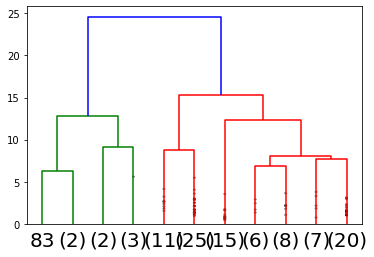

In [13]:
dendrogram(Z, 
           truncate_mode = 'lastp', #pвключен режим показывать последние 'p' кластеров  
           p=11,                     #отобразить последние 11 кластеров 
           leaf_rotation = 0,       #угол поворота надписей по оси  
           leaf_font_size = 20,     #размер шрифта  
           show_contracted = True)  # рисовать черные точки на высотах предыдущих слияний кластеров
plt.show()

Для выделения некоторого разбиения объектов на кластеры воспользуемся функцией `fcluster()`, которая на основе построенной матрицы связей `Z` выделяет некоторое разбиение на кластеры, исходя из задаваемых польователем критериев. В качестве критерия можно указать либо максимальное количество кластеров `criterion='maxclust'`, либо расстоние `criterion='distance'`.     
 
В первом случае мы указываем требуемое (желаемое) максимальное число кластеров, т.е. используем критерий `criterion='maxclust'`. На выходе имеем массив с указанием номера кластера, которому принадлежит соответствующий исходный объект 

In [14]:
label=fcluster(Z, 7, criterion='maxclust')
print(label)

[5 7 5 5 5 5 7 6 5 5 3 5 5 5 5 6 7 5 7 6 6 5 5 2 7 5 7 5 7 7 5 5 5 5 7 7 7
 7 7 7 5 7 7 7 7 7 6 6 7 5 6 6 7 1 4 7 4 3 5 5 7 7 7 7 5 7 6 7 7 7 6 4 3 7
 7 7 6 6 4 4 4 7 6 1 4 7 7 6 2 7 6 4 4 7 4 1 7 4 7 7]


Для анализа каждого из выделенных кластеров реализуем следующие действия:    
1) добавим в исходный датафрейм новый столбец `Номер кластера`;    
2) в цикле `for` с использоанием механизма группировки датафрейма `groupby` выведем объекты кластеров

In [15]:
df.loc[:,'Номер кластера']=label # добавление нового столбца с метками 
for i, group in df.groupby('Номер кластера'): # вывод элементов каждого кластера  
    print('=' * 10)
    print('cluster {}'.format(i))
    print(group)

cluster 1
    Код  Возраст  Среднемесячный расход  Средняя продолжительность разговоров  \
53   53       31                1922.36                                  14.4   
83   84       33                 508.22                                   5.2   
95   96       29                1977.50                                  18.2   

    Звонков днем за месяц  Звонков вечером за месяц  Звонков ночью за месяц  \
53                    109                       123                      25   
83                    100                        64                      30   
95                    100                        78                      42   

    Звонки в другие города  Звонки в другие страны  \
53                       6                       0   
83                      49                       2   
95                      38                       0   

    Доля звонков на стационарные телефоны  Количество SMS за месяц  \
53                                      5                    

Во втором случае мы указываем расстояние по оси ординат, на котором будем проводить линию среза, т.е. используем критерий `criterion='distance'`. На выходе имеем массив с указанием номера кластера, которому принадлежит соответствующий исходный объект.     
Пусть, например, мы хотим узнать какие кластеры объединились на расстоянии 7. Для наглядности на дендрограмме нарисуем соответствующую линию среза `y=10`.   

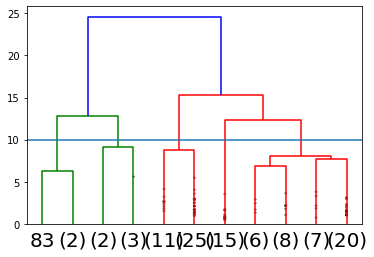

In [16]:
plt.axhline(y=10) #рисуем горизонтальную линию
dendrogram(Z, 
           truncate_mode = 'lastp', #pвключен режим показывать последние 'p' кластеров  
           p=11,                     #отобразить последние 11 кластеров 
           leaf_rotation = 0,       #угол поворота надписей по оси  
           leaf_font_size = 20,     #размер шрифта  
           show_contracted = True)  # рисовать черные точки на высотах предыдущих слияний кластеров
plt.show()

На рисунке показано, что на этом уровне имеется 5 кластеров. Выделим эти кластеры с использованием функции `fcluster()`, задав критерий расстояния. Имеем

In [44]:
label1=fcluster(Z, 10, criterion='distance')
print(label1)

[3 5 3 3 3 3 5 4 3 3 2 3 3 3 3 4 5 3 5 4 4 3 3 2 5 3 5 3 5 5 3 3 3 3 5 5 5
 5 5 5 3 5 5 5 5 5 4 4 5 3 4 4 5 1 3 5 3 2 3 3 5 5 5 5 3 5 4 5 5 5 4 3 2 5
 5 5 4 4 3 3 3 5 4 1 3 5 5 4 2 5 4 3 3 5 3 1 5 3 5 5]


Видим, что построено распределение исходных элементов на 5 кластеров. Для анализа каждого кластера можно проделать последовательность действий, аналогичную выше рассмотренной.  

ДОПОЛНИТЕЛЬНАЯ ИНФОРМАЦИЯ: Следует заметить, что при использовании значения `distance` количество кластеров уменьшается с ростом расстояния -- значения параметра `t`. ЖЕЛАТЕЛЬНО разместить соответствующий график зависимости.  

### 4.3 Метод локтя

Для поиска "оптимального" числа кластеров воспользуемся методом локтя -- графическим методом. 

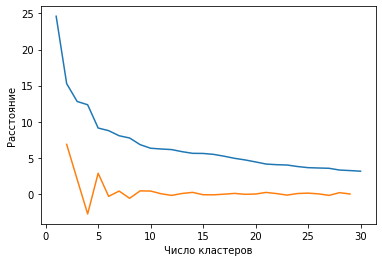

clusters: 2


In [45]:
last = Z[-30:, 2] # в матрице связей берем последние 20 значений расстояний между кластерами 
last_rev = last[::-1] #переписываем в обратном порядке  
idxs = np.arange(1, len(last) + 1,1) #генерируем список начальное значение 1, конечное --- число элементов массива, шаг 1
plt.xlabel('Число кластеров')
plt.ylabel('Расстояние')
plt.plot(idxs, last_rev) #отображение графика 

#далее идет расчет вторых разностей, пример взят из [2]  
acceleration = np.diff(last, 2)  # 2nd derivative of the distances
acceleration_rev = acceleration[::-1]
plt.plot(idxs[:-2] + 1, acceleration_rev)
plt.show()
k = acceleration_rev.argmax() + 2  # if idx 0 is the max of this we want 2 clusters
print("clusters:", k)

На данном графике показана зависимость расстояния между кластерами от номера шага итерации, на котором два ближайших кластера объединяются в новый --- синия линия.Оранжевая линия показывает, как меняется ускорение --- быстрота изменения расстояния между объединяемыми кластерами. В данном случае оптимальным числом кластеров может считаться 5.

Литература
1. Маккинли У. Python и анализ данных. - М.: ДМК Пресс, 2015. – 482 с.
2. https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/
3. https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html

Масштабирование признаков http://sebastianraschka.com/Articles/2014_about_feature_scaling.html    
Сравнение методов кластеризации https://scikit-learn.org/stable/modules/clustering.html# 

# Замечания 
Отредактировать текст с научной предметной лексикой -- линия среза 

# Черновики

In [ ]:
Z = linkage(X, method='ward') 
r=plt.figure()
dendrogram(Z, 
#           truncate_mode = 'lastp', #включен режим показывать последние 'p' кластеров  
#           p=4,                     #задается параметр 'p' 
           leaf_rotation = 0,       #угол поворота надписей по оси  
           leaf_font_size = 20,     #размер шрифта  
           show_contracted = True)
r.savefig('2.png', dpi = 300)

In [ ]:
label=fcluster(Z, 2, criterion='distance')

In [ ]:
X.loc[:,'label']=label

In [ ]:
for i, group 

## 5. Неиерархическая кластеризация: метод k-средних

In [15]:
from scipy.cluster.vq import vq, kmeans, whiten, kmeans2

In [ ]:
whitened = whiten(X)
codebook, distortion=kmeans(whitened,3)

In [ ]:
centroid, label = kmeans2(X, 3, minit='points')

In [ ]:
label